<a href="https://www.kaggle.com/code/sayedul45/rain-prediction-australia-using-ann?scriptVersionId=177218298" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

 # Importing Libraries

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import datetime
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.model_selection import train_test_split


from keras.layers import Dense , BatchNormalization , Dropout , LSTM 
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import callbacks
from keras.callbacks import EarlyStopping


from sklearn.metrics import accuracy_score,f1_score , precision_score , recall_score , classification_report , confusion_matrix 

2024-05-12 13:02:50.361159: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 13:02:50.361272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 13:02:50.538403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
np.random.seed(0)

In [3]:
data = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

# Data Visualization

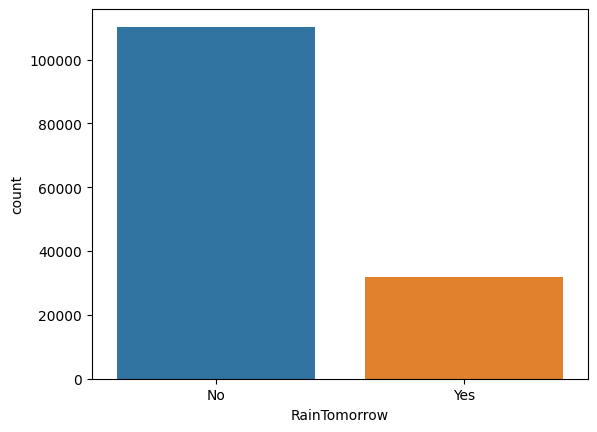

In [5]:
# first let us check if the dataset is imbalance or balance according to target column

sns.countplot(x=data['RainTomorrow'])
plt.show()

## Parse Date into DateTime

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

In [7]:
len = data['Location'].str.len()
len.value_counts()

Location
8     24898
6     18850
10    18139
9     16863
7     15103
12    12098
11    12097
5     10789
13     9027
4      4587
16     3009
Name: count, dtype: int64

In [8]:
data['year']=data.Date.dt.year

In [9]:
# Now i'm gonna convert month and days into cyclic continuous values

def encode(data,col,max_value):
    data[col+'_sin'] = np.sin(2 * np.pi * data[col]/max_value)
    data[col+'_cos'] = np.cos(2 * np.pi * data[col]/max_value)
    return data

In [10]:
data['month'] = data.Date.dt.month
data = encode(data, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data,'day',31)

In [11]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,No,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,No,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,No,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,No,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,No,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


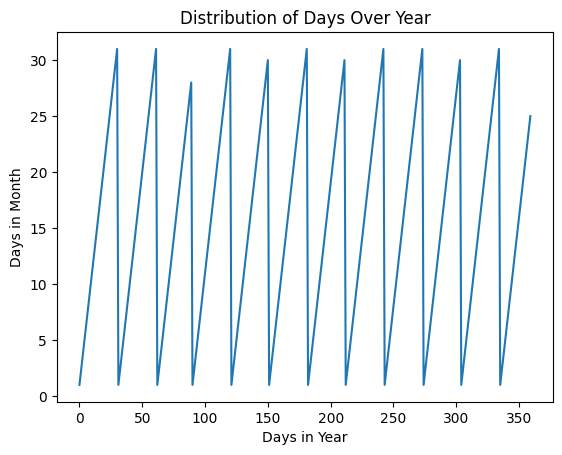

In [12]:
# Roughly a year span 

section = data[:360]
plt.plot(section['day'])
plt.xlabel('Days in Year')
plt.ylabel('Days in Month')
plt.title('Distribution of Days Over Year')
plt.show()


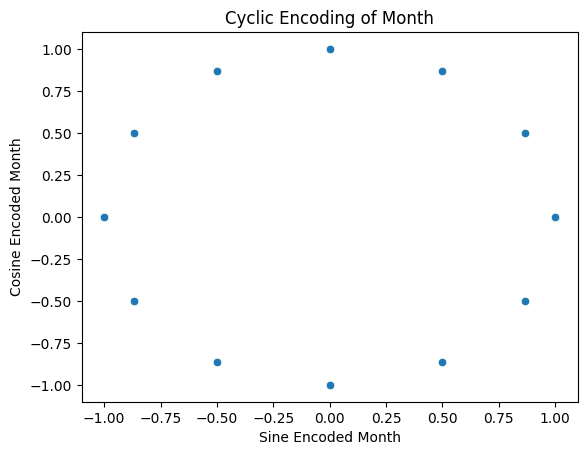

In [13]:
sns.scatterplot(x='month_sin',y='month_cos',data=data)
plt.title('Cyclic Encoding of Month')
plt.xlabel('Sine Encoded Month')
plt.ylabel('Cosine Encoded Month')
plt.show()

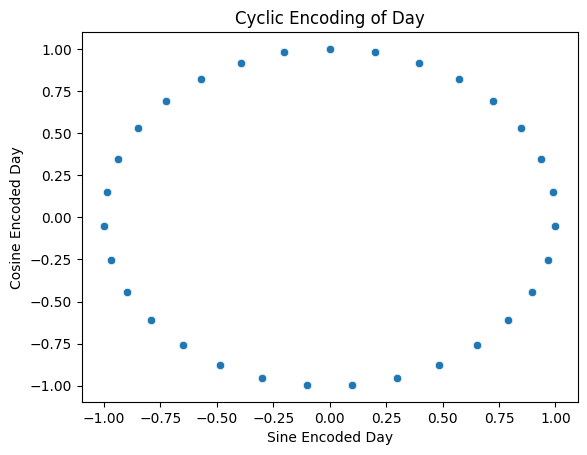

In [14]:
sns.scatterplot(x='day_sin',y='day_cos',data=data)
plt.title('Cyclic Encoding of Day')
plt.xlabel('Sine Encoded Day')
plt.ylabel('Cosine Encoded Day')
plt.show()

# Dealing with missing values separately

## Categorical Columns

In [15]:
# Get the list of Categorical columns

cat = (data.dtypes=='O')
object_cols=list(cat[cat].index)

print(f'Categorical Columns are :')
print(object_cols)


Categorical Columns are :
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


In [16]:
# Missing values in categorical columns

for feature in object_cols:
    print(feature,data[feature].isna().sum())

Location 0
WindGustDir 10326
WindDir9am 10566
WindDir3pm 4228
RainToday 3261
RainTomorrow 3267


In [17]:
# Filling  missing values corresponding there mode values
for feature in object_cols:
    data[feature].fillna(data[feature].mode()[0],inplace=True)

## Numerical Columns

In [18]:
# Get the list of the numerical columns

t =(data.dtypes=='float64')

numeric_cols = list(t[t].index)

print('Numerical Columns are : ')
print(numeric_cols)

Numerical Columns are : 
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [19]:
# Missing values in numerical columns 

for feature in numeric_cols:
    print(feature , data[feature].isna().sum())

MinTemp 1485
MaxTemp 1261
Rainfall 3261
Evaporation 62790
Sunshine 69835
WindGustSpeed 10263
WindSpeed9am 1767
WindSpeed3pm 3062
Humidity9am 2654
Humidity3pm 4507
Pressure9am 15065
Pressure3pm 15028
Cloud9am 55888
Cloud3pm 59358
Temp9am 1767
Temp3pm 3609
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [20]:
# Filling missing values with median value of specific columns

for feature in numeric_cols:
    data[feature].fillna(data[feature].median(),inplace=True)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  object        
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  object        
 10  WindDir3pm     145460 non-null  object        
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [22]:
data['year'].min()

2007

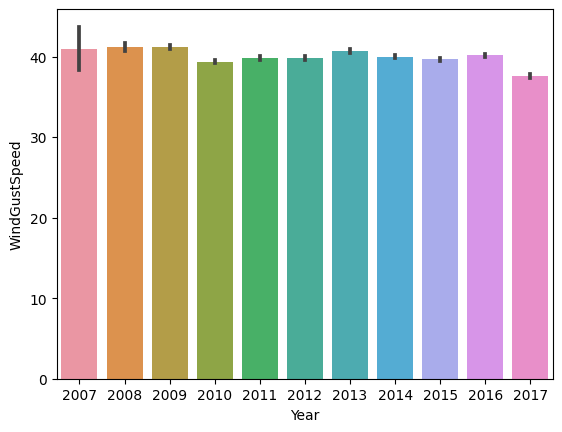

In [23]:
sns.barplot(x='year',y='WindGustSpeed',data=data)
plt.xlabel('Year')
plt.ylabel('WindGustSpeed')
plt.show()

# Data Preprocessing

### Lebel Encoding the Categorical Columns

In [24]:
label_encoder = LabelEncoder()
for feature in object_cols:
    data[feature] = label_encoder.fit_transform(data[feature])

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  int64         
 2   MinTemp        145460 non-null  float64       
 3   MaxTemp        145460 non-null  float64       
 4   Rainfall       145460 non-null  float64       
 5   Evaporation    145460 non-null  float64       
 6   Sunshine       145460 non-null  float64       
 7   WindGustDir    145460 non-null  int64         
 8   WindGustSpeed  145460 non-null  float64       
 9   WindDir9am     145460 non-null  int64         
 10  WindDir3pm     145460 non-null  int64         
 11  WindSpeed9am   145460 non-null  float64       
 12  WindSpeed3pm   145460 non-null  float64       
 13  Humidity9am    145460 non-null  float64       
 14  Humidity3pm    145460 non-null  float64       
 15  

In [26]:
# Prepairing the features for scaling 

features = data.drop(['RainTomorrow','day','month','Date'],axis=1)

target = data['RainTomorrow']

In [27]:
features

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,year,month_sin,month_cos,day_sin,day_cos
0,2,13.4,22.9,0.6,4.8,8.4,13,44.0,13,14,...,8.0,5.0,16.9,21.8,0,2008,-2.449294e-16,1.0,0.201299,0.979530
1,2,7.4,25.1,0.0,4.8,8.4,14,44.0,6,15,...,5.0,5.0,17.2,24.3,0,2008,-2.449294e-16,1.0,0.394356,0.918958
2,2,12.9,25.7,0.0,4.8,8.4,15,46.0,13,15,...,5.0,2.0,21.0,23.2,0,2008,-2.449294e-16,1.0,0.571268,0.820763
3,2,9.2,28.0,0.0,4.8,8.4,4,24.0,9,0,...,5.0,5.0,18.1,26.5,0,2008,-2.449294e-16,1.0,0.724793,0.688967
4,2,17.5,32.3,1.0,4.8,8.4,13,41.0,1,7,...,7.0,8.0,17.8,29.7,0,2008,-2.449294e-16,1.0,0.848644,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,41,2.8,23.4,0.0,4.8,8.4,0,31.0,9,1,...,5.0,5.0,10.1,22.4,0,2017,1.224647e-16,-1.0,-0.897805,-0.440394
145456,41,3.6,25.3,0.0,4.8,8.4,6,22.0,9,3,...,5.0,5.0,10.9,24.5,0,2017,1.224647e-16,-1.0,-0.968077,-0.250653
145457,41,5.4,26.9,0.0,4.8,8.4,3,37.0,9,14,...,5.0,5.0,12.5,26.1,0,2017,1.224647e-16,-1.0,-0.998717,-0.050649
145458,41,7.8,27.0,0.0,4.8,8.4,9,28.0,10,3,...,3.0,2.0,15.1,26.0,0,2017,1.224647e-16,-1.0,-0.988468,0.151428


In [28]:
col_names = list(features.columns)
scaler = StandardScaler()
features = scaler.fit_transform(features)
features = pd.DataFrame(features , columns = col_names)

In [29]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,145460.0,7.815677e-18,1.000003,-1.672228,-0.899139,0.014511,0.857881,1.701250
MinTemp,145460.0,-4.501830e-16,1.000003,-3.250525,-0.705659,-0.030170,0.723865,3.410112
MaxTemp,145460.0,3.001220e-16,1.000003,-3.952405,-0.735852,-0.086898,0.703133,3.510563
Rainfall,145460.0,7.815677e-18,1.000003,-0.275097,-0.275097,-0.275097,-0.203581,43.945571
Evaporation,145460.0,-3.282584e-17,1.000003,-1.629472,-0.371139,-0.119472,0.006361,43.985108
Sunshine,145460.0,-5.424080e-16,1.000003,-2.897217,0.076188,0.148710,0.257494,2.360634
WindGustDir,145460.0,6.252542e-18,1.000003,-1.724209,-0.872075,0.193094,1.045228,1.471296
WindGustSpeed,145460.0,1.824961e-16,1.000003,-2.588407,-0.683048,-0.073333,0.460168,7.243246
WindDir9am,145460.0,7.190423e-17,1.000003,-1.550000,-0.885669,0.000105,0.885879,1.771653
WindDir3pm,145460.0,8.284618e-17,1.000003,-1.718521,-0.837098,0.044324,0.925747,1.586813


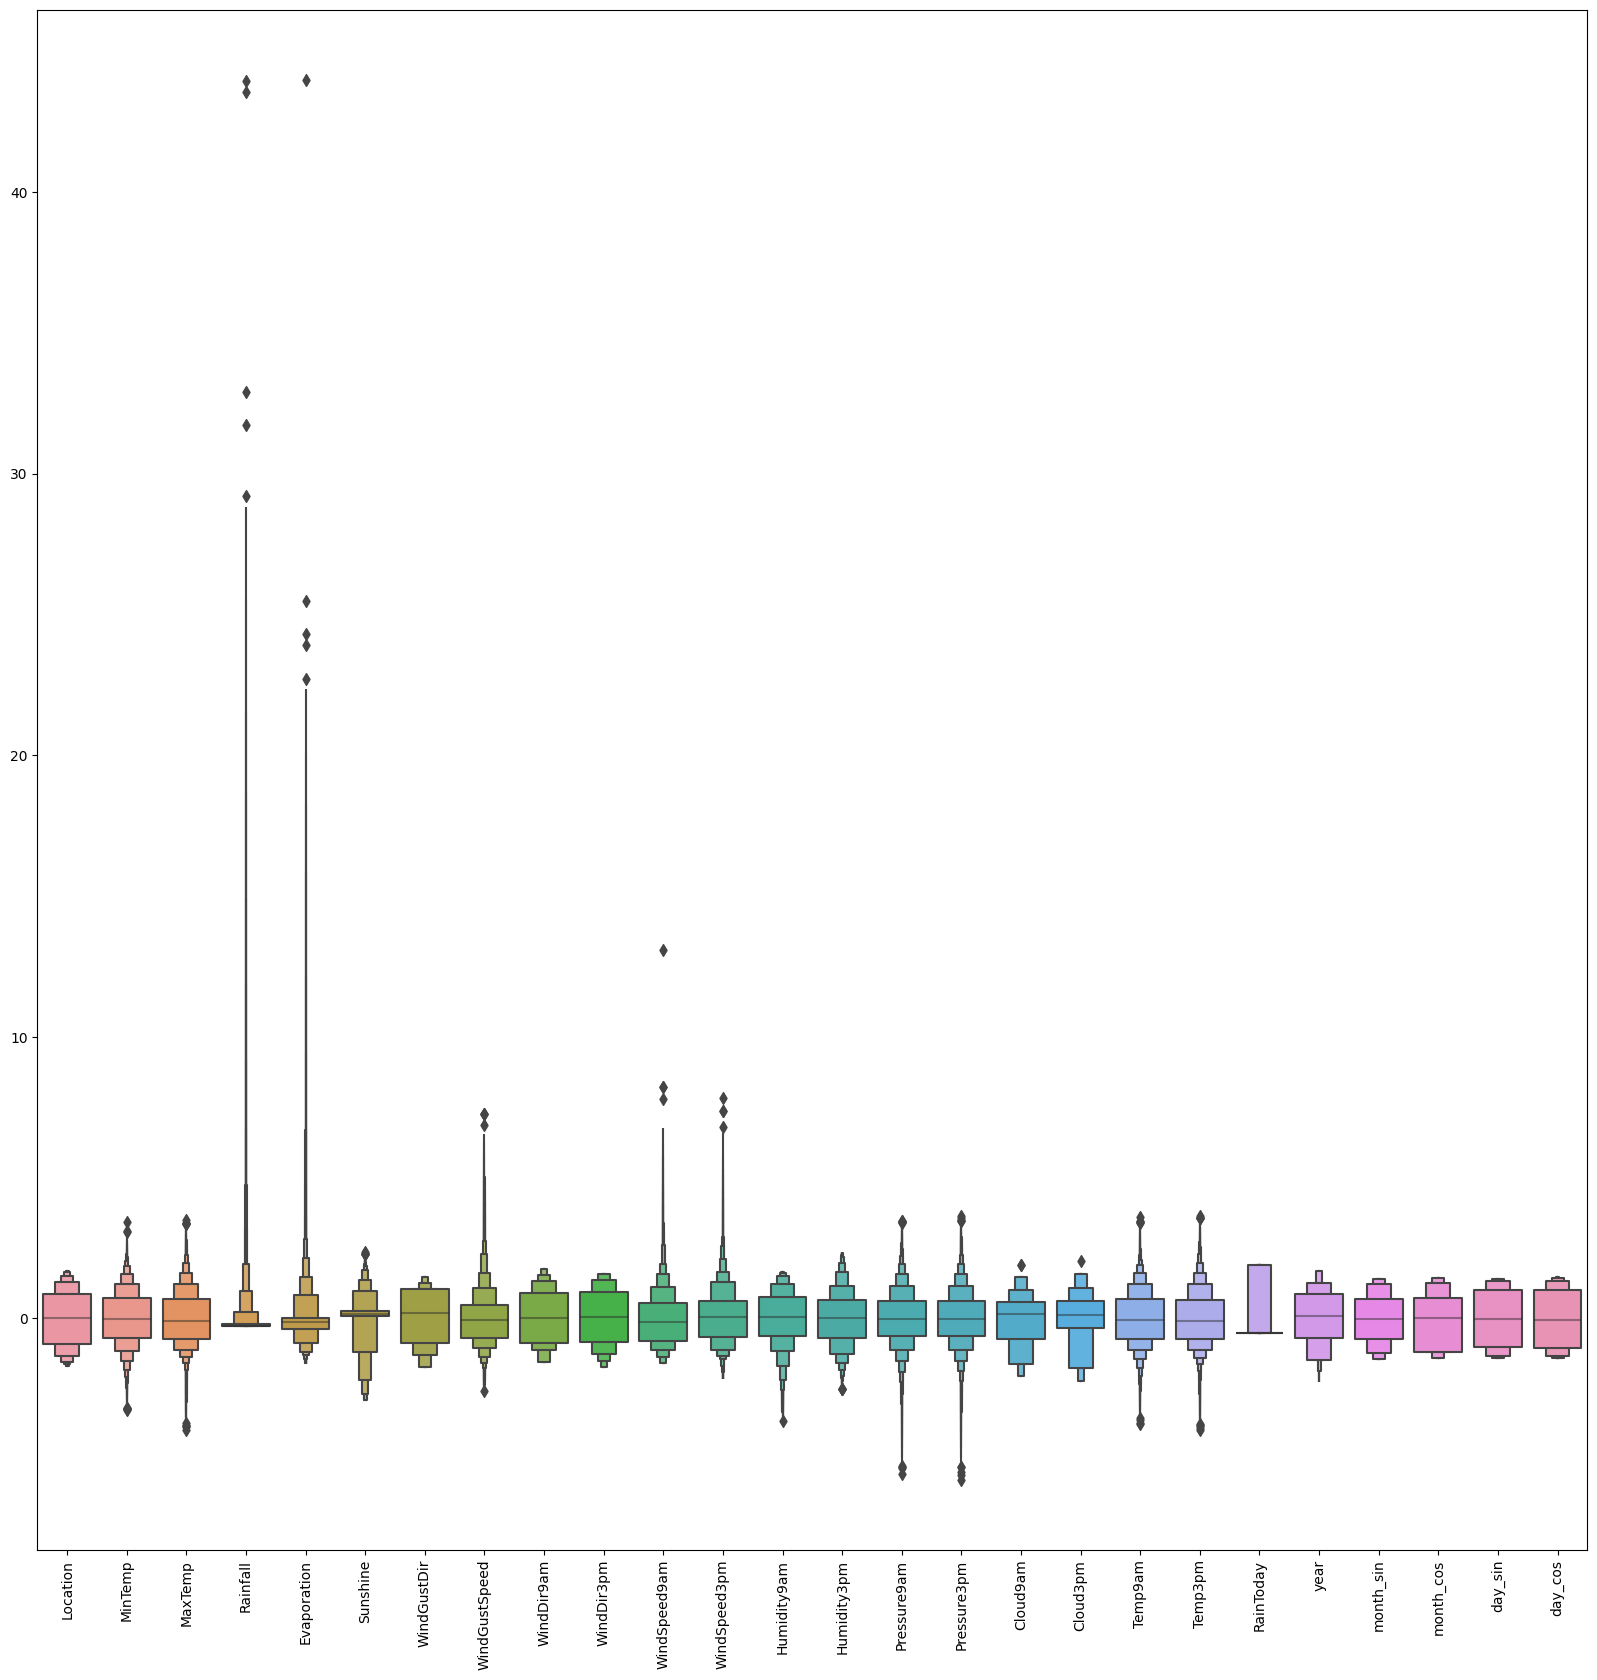

In [30]:
# Detecting Outliers 

plt.figure(figsize=(20,20))

sns.boxenplot(data=features)
plt.xticks(rotation=90)
plt.show()

In [31]:
#full data for 
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"]<2.3)&(features["MinTemp"]>-2.3)]
features = features[(features["MaxTemp"]<2.3)&(features["MaxTemp"]>-2)]
features = features[(features["Rainfall"]<4.5)]
features = features[(features["Evaporation"]<2.8)]
features = features[(features["Sunshine"]<2.1)]
features = features[(features["WindGustSpeed"]<4)&(features["WindGustSpeed"]>-4)]
features = features[(features["WindSpeed9am"]<4)]
features = features[(features["WindSpeed3pm"]<2.5)]
features = features[(features["Humidity9am"]>-3)]
features = features[(features["Humidity3pm"]>-2.2)]
features = features[(features["Pressure9am"]< 2)&(features["Pressure9am"]>-2.7)]
features = features[(features["Pressure3pm"]< 2)&(features["Pressure3pm"]>-2.7)]
features = features[(features["Cloud9am"]<1.8)]
features = features[(features["Cloud3pm"]<2)]
features = features[(features["Temp9am"]<2.3)&(features["Temp9am"]>-2)]
features = features[(features["Temp3pm"]<2.3)&(features["Temp3pm"]>-2)]


features.shape

(127536, 27)

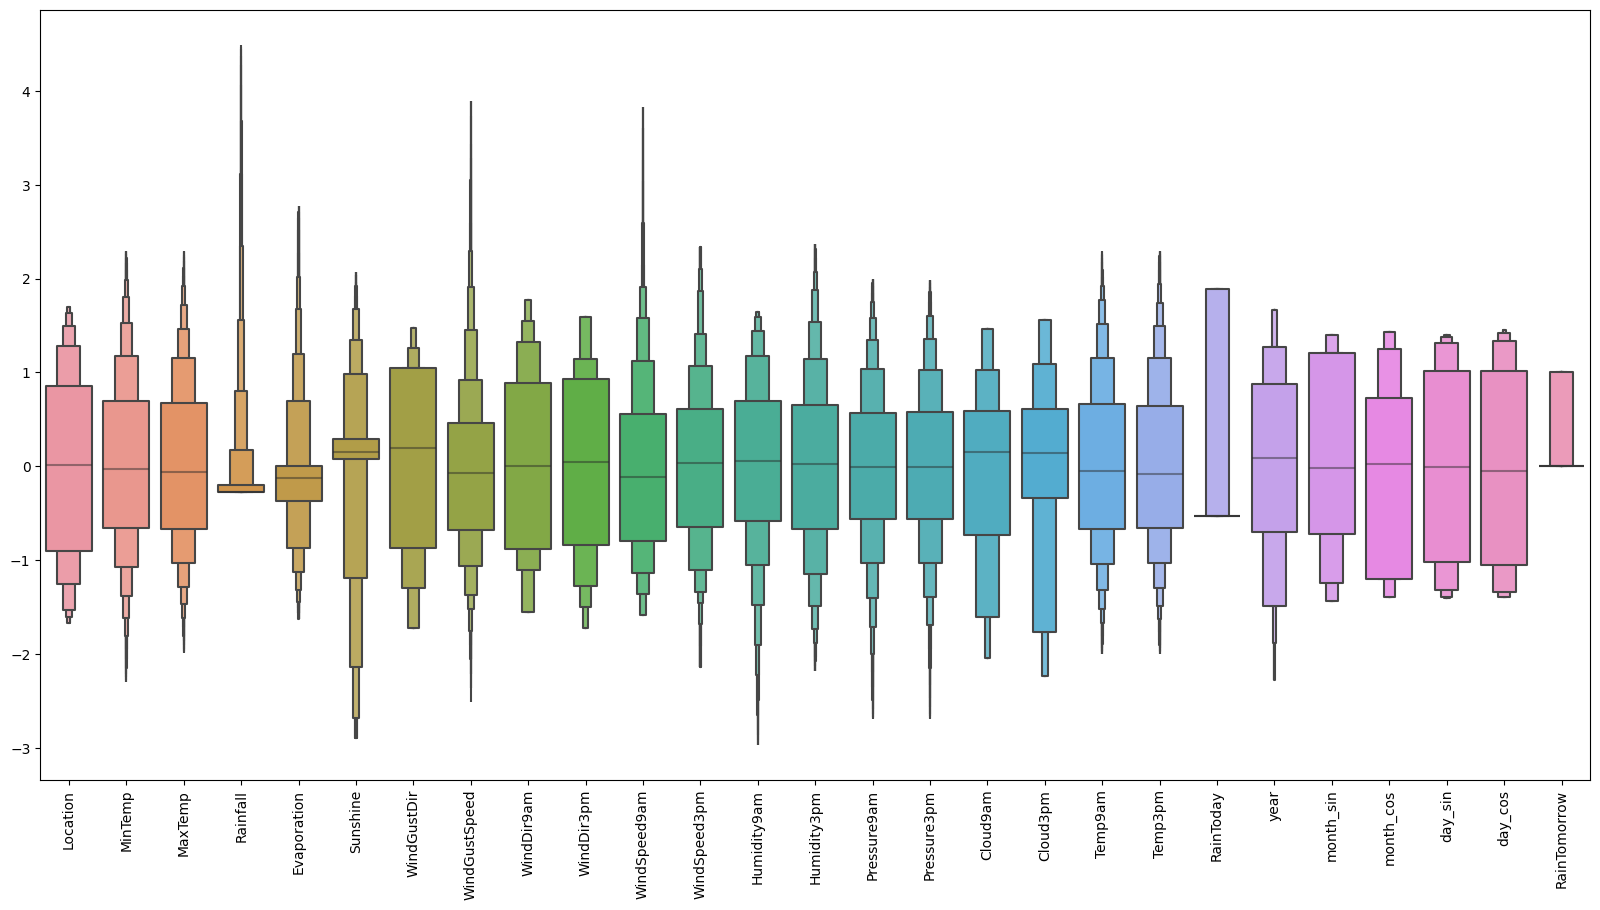

In [32]:
# Looking at the scaled features without outliers
plt.figure(figsize=(20,10))

sns.boxenplot(data=features)
plt.xticks(rotation=90)
plt.show()

# Model Building

In [33]:
# Selecting dependent and Independent features
X=features.drop('RainTomorrow',axis=1)
y=features['RainTomorrow']

In [34]:
# Splitting train and test set data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [35]:
# Early Stopping
early_stop = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,

)

In [36]:
# Initializing NN 

model = Sequential()



# Layers 

#input layer
model.add(Dense(units=32,kernel_initializer='uniform',activation='relu',input_dim=26))
model.add(Dense(units=64,kernel_initializer='uniform',activation='relu'))
model.add(Dense(units=16,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=64,kernel_initializer='uniform',activation='relu'))
model.add(Dropout(0.25))

#output layer
model.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))


# Compile the model
optimizer = Adam(learning_rate=0.00009)
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])


# Train ANN Model
history = model.fit(X_train,y_train,batch_size=32,epochs=64,callbacks=[early_stop],validation_split=0.2)


Epoch 1/64
  81/2551 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7923 - loss: 0.6920

I0000 00:00:1715518999.010518      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715518999.026246      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2551/2551 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7961 - loss: 0.4886

W0000 00:00:1715519008.116649      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


2551/2551 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7961 - loss: 0.4885 - val_accuracy: 0.8381 - val_loss: 0.3799
Epoch 2/64
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8430 - loss: 0.3800 - val_accuracy: 0.8415 - val_loss: 0.3688
Epoch 3/64
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8432 - loss: 0.3706 - val_accuracy: 0.8433 - val_loss: 0.3632
Epoch 4/64
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8415 - loss: 0.3709 - val_accuracy: 0.8447 - val_loss: 0.3604
Epoch 5/64
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8485 - loss: 0.3609 - val_accuracy: 0.8449 - val_loss: 0.3594
Epoch 6/64
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8491 - loss: 0.3573 - val_accuracy: 0.8450 - val_loss: 0.3581
Epoch 7/64
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8470 - loss: 0.3626 - val_accuracy: 0.8456 - val_loss: 0.3581
Epoch 8/64
2551/2551 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8486 - loss: 0.3564 - val_accura

In [37]:
history_df = pd.DataFrame(history.history)

In [38]:
history_df

,accuracy,loss,val_accuracy,val_loss
0,0.813224,0.421888,0.838087,0.379899
1,0.842518,0.376504,0.841468,0.368798
2,0.844392,0.367892,0.843281,0.363226
3,0.845544,0.364016,0.844703,0.360383
4,0.847296,0.361394,0.844948,0.359448
5,0.847847,0.359821,0.844997,0.358141
6,0.847884,0.359240,0.845585,0.358111
7,0.848374,0.357730,0.845732,0.356725
8,0.848583,0.356656,0.844703,0.356136
9,0.848472,0.355957,0.845928,0.355565


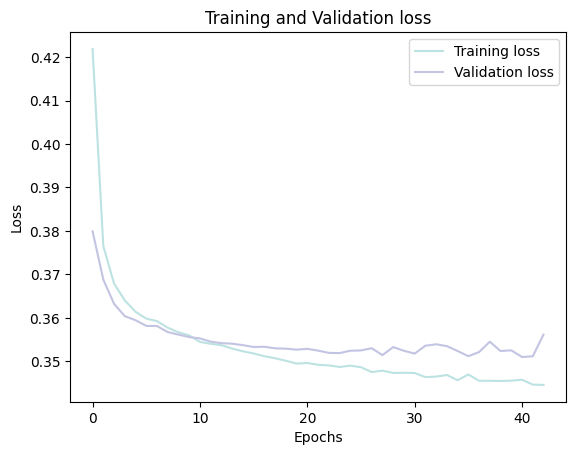

In [39]:
plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

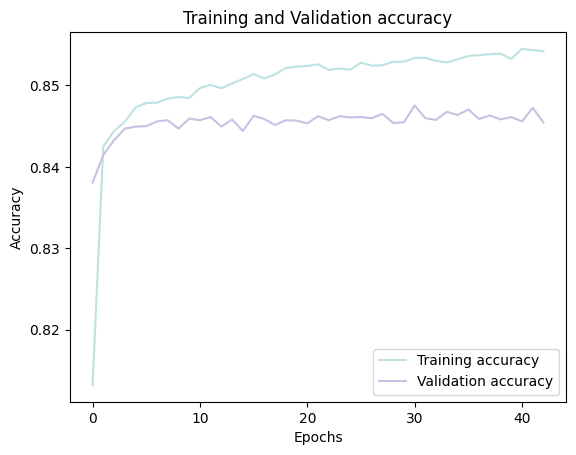

In [40]:
plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
model.evaluate(X_test,y_test)

798/798 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8529 - loss: 0.3438


[0.34671643376350403, 0.8505566716194153]

# Prediction

In [42]:
y_pred = model.predict(X_test)

128/798 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715519246.173992      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


798/798 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [43]:
y_pred = (y_pred > 0.5)

In [44]:
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     20110
           1       0.71      0.50      0.59      5398

    accuracy                           0.85     25508
   macro avg       0.79      0.72      0.75     25508
weighted avg       0.84      0.85      0.84     25508



In [46]:
# plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[19002,  1108],
       [ 2704,  2694]])

In [47]:
np.sum(cf_matrix)

25508

In [48]:
cf_matrix/np.sum(cf_matrix)

array([[0.74494276, 0.04343735],
       [0.10600596, 0.10561393]])

<Axes: >

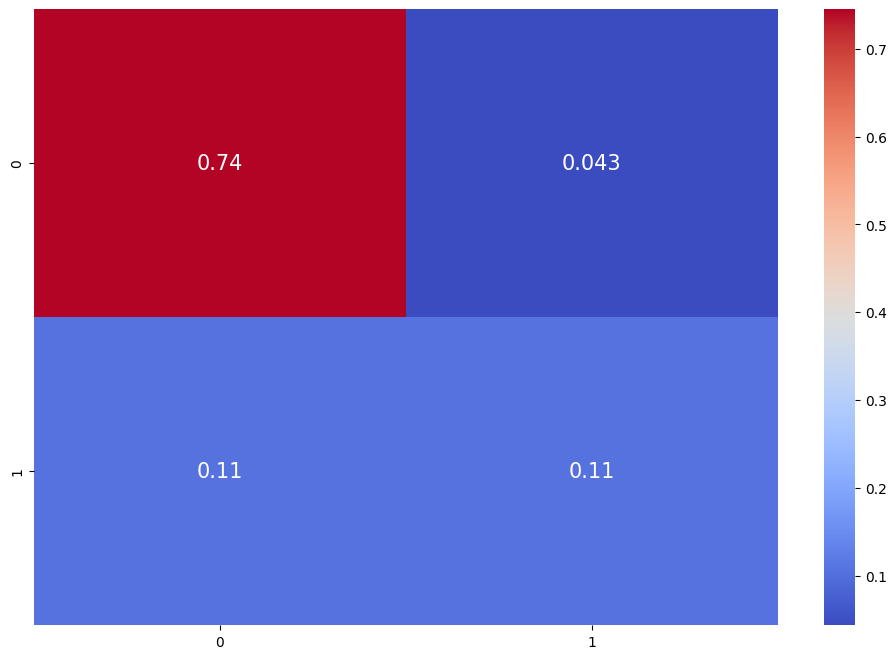

In [49]:
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = 'coolwarm', annot = True,annot_kws = {'size':15})